In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder # data preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder 
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from functools import partial

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 500

###  Loading the data

In [2]:
path = "/kaggle/input/tanzania-tourism/"
train = pd.read_csv(path + "Train.csv")
test = pd.read_csv(path + "Test.csv")
var_df = pd.read_csv(path + "VariableDefinitions.csv")


display("train dataframe",
        " ",
        train.head(),
        "test dataframe",
        " ",
        test.head(),
        "var_df",
        " ",
        var_df)

'train dataframe'

' '

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost
0,tour_0,SWIZERLAND,45-64,Friends/Relatives,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,No,No,No,No,No,No,No,13.0,0.0,Cash,No,Friendly People,674602.5
1,tour_10,UNITED KINGDOM,25-44,NaN,1.0,0.0,Leisure and Holidays,Cultural tourism,others,Independent,No,No,No,No,No,No,No,14.0,7.0,Cash,Yes,"Wonderful Country, Landscape, Nature",3214906.5
2,tour_1000,UNITED KINGDOM,25-44,Alone,0.0,1.0,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,No,No,No,No,No,No,No,1.0,31.0,Cash,No,Excellent Experience,3315000.0
3,tour_1002,UNITED KINGDOM,25-44,Spouse,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,No,Yes,Yes,Yes,Yes,Yes,No,11.0,0.0,Cash,Yes,Friendly People,7790250.0
4,tour_1004,CHINA,1-24,NaN,1.0,0.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Independent,No,No,No,No,No,No,No,7.0,4.0,Cash,Yes,No comments,1657500.0


'test dataframe'

' '

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing
0,tour_1,AUSTRALIA,45-64,Spouse,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,Yes,Yes,Yes,10,3,Cash,Yes,Wildlife
1,tour_100,SOUTH AFRICA,25-44,Friends/Relatives,0.0,4.0,Business,Wildlife tourism,Tanzania Mission Abroad,Package Tour,Yes,Yes,No,No,No,No,No,13,0,Cash,No,"Wonderful Country, Landscape, Nature"
2,tour_1001,GERMANY,25-44,Friends/Relatives,3.0,0.0,Leisure and Holidays,Beach tourism,"Friends, relatives",Independent,No,No,No,No,No,No,No,7,14,Cash,No,No comments
3,tour_1006,CANADA,24-Jan,Friends/Relatives,2.0,0.0,Leisure and Holidays,Cultural tourism,others,Independent,No,No,No,No,No,No,No,0,4,Cash,Yes,Friendly People
4,tour_1009,UNITED KINGDOM,45-64,Friends/Relatives,2.0,2.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Package Tour,Yes,Yes,Yes,Yes,No,No,No,10,0,Cash,Yes,Friendly People


'var_df'

' '

,Column Name,Definition
0,id,Unique identifier for each tourist
1,country,The country a tourist coming from.
2,age_group,The age group of a tourist.
3,travel_with,The relation of people a tourist travel with t...
4,total_female,Total number of females
5,total_male,Total number of males
6,purpose,The purpose of visiting Tanzania
7,main_activity,The main activity of tourism in Tanzania
8,infor_source,The source of information about tourism in Tan...
9,tour_arrangment,The arrangment of visiting Tanzania


## Data Sanity Checks


In [3]:
train.shape, test.shape

((4809, 23), (1601, 22))

In [4]:
train.duplicated().sum()

0

In [5]:
train.info(),test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     4809 non-null   object 
 1   country                4809 non-null   object 
 2   age_group              4809 non-null   object 
 3   travel_with            3695 non-null   object 
 4   total_female           4806 non-null   float64
 5   total_male             4804 non-null   float64
 6   purpose                4809 non-null   object 
 7   main_activity          4809 non-null   object 
 8   info_source            4809 non-null   object 
 9   tour_arrangement       4809 non-null   object 
 10  package_transport_int  4809 non-null   object 
 11  package_accomodation   4809 non-null   object 
 12  package_food           4809 non-null   object 
 13  package_transport_tz   4809 non-null   object 
 14  package_sightseeing    4809 non-null   object 
 15  pack

(None, None)

In [6]:
numerical_cols = train.select_dtypes(include= 'number').columns
numerical_cols

Index(['total_female', 'total_male', 'night_mainland', 'night_zanzibar',
       'total_cost'],
      dtype='object')

In [7]:
categorical_cols = train.select_dtypes(include= 'object').columns
categorical_cols

Index(['ID', 'country', 'age_group', 'travel_with', 'purpose', 'main_activity',
       'info_source', 'tour_arrangement', 'package_transport_int',
       'package_accomodation', 'package_food', 'package_transport_tz',
       'package_sightseeing', 'package_guided_tour', 'package_insurance',
       'payment_mode', 'first_trip_tz', 'most_impressing'],
      dtype='object')

In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
total_female,4806.0,9.267582e-01,1.288242e+00,0.0,0.0,1.0,1.0,49.0
total_male,4804.0,1.009575e+00,1.138865e+00,0.0,1.0,1.0,1.0,44.0
night_mainland,4809.0,8.488043e+00,1.042762e+01,0.0,3.0,6.0,11.0,145.0
night_zanzibar,4809.0,2.304429e+00,4.227080e+00,0.0,0.0,0.0,4.0,61.0
total_cost,4809.0,8.114389e+06,1.222490e+07,49000.0,812175.0,3397875.0,9945000.0,99532875.0


In [9]:
train.describe(include= "object").T

,count,unique,top,freq
ID,4809,4809,tour_0,1
country,4809,105,UNITED STATES OF AMERICA,695
age_group,4809,4,25-44,2487
travel_with,3695,5,Alone,1265
purpose,4809,7,Leisure and Holidays,2840
main_activity,4809,9,Wildlife tourism,2259
info_source,4809,8,"Travel, agent, tour operator",1913
tour_arrangement,4809,2,Independent,2570
package_transport_int,4809,2,No,3357
package_accomodation,4809,2,No,2602


In [10]:
for col in train.columns:
    if col in numerical_cols:
        train[col] = train[col].fillna(0)

# Confirm that there aren't any missing values
train[train.columns.difference(['cost_category'])].isna().sum()


ID                          0
age_group                   0
country                     0
first_trip_tz               0
info_source                 0
main_activity               0
most_impressing           313
night_mainland              0
night_zanzibar              0
package_accomodation        0
package_food                0
package_guided_tour         0
package_insurance           0
package_sightseeing         0
package_transport_int       0
package_transport_tz        0
payment_mode                0
purpose                     0
total_cost                  0
total_female                0
total_male                  0
tour_arrangement            0
travel_with              1114
dtype: int64

In [11]:
for col in test.columns:
    if col in numerical_cols:
        test[col] = test[col].fillna(0)

# Confirm that there aren't any missing values
test[test.columns.difference(['cost_category'])].isna().sum()

ID                         0
age_group                  0
country                    0
first_trip_tz              0
info_source                0
main_activity              0
most_impressing          111
night_mainland             0
night_zanzibar             0
package_accomodation       0
package_food               0
package_guided_tour        0
package_insurance          0
package_sightseeing        0
package_transport_int      0
package_transport_tz       0
payment_mode               0
purpose                    0
total_female               0
total_male                 0
tour_arrangement           0
travel_with              327
dtype: int64

In [12]:
# Filling missing values in categorical columns using the mode
for col in categorical_cols:
    train[col].fillna(train[col].mode()[0],inplace = True)
    
#Checkin for remaining missing values

print('Remaining missing values:\n',train.isna().sum())
    

Remaining missing values:
 ID                       0
country                  0
age_group                0
travel_with              0
total_female             0
total_male               0
purpose                  0
main_activity            0
info_source              0
tour_arrangement         0
package_transport_int    0
package_accomodation     0
package_food             0
package_transport_tz     0
package_sightseeing      0
package_guided_tour      0
package_insurance        0
night_mainland           0
night_zanzibar           0
payment_mode             0
first_trip_tz            0
most_impressing          0
total_cost               0
dtype: int64


In [13]:
for col in test.columns:
    if col in categorical_cols:
        fillna_const = 'MISSING_VALUE'
        test[col] = test[col].astype('str').fillna(fillna_const)
    

# Confirm that there aren't any missing values
test[test.columns.difference(['total_cost'])].isna().sum()

ID                       0
age_group                0
country                  0
first_trip_tz            0
info_source              0
main_activity            0
most_impressing          0
night_mainland           0
night_zanzibar           0
package_accomodation     0
package_food             0
package_guided_tour      0
package_insurance        0
package_sightseeing      0
package_transport_int    0
package_transport_tz     0
payment_mode             0
purpose                  0
total_female             0
total_male               0
tour_arrangement         0
travel_with              0
dtype: int64

In [14]:
train.isnull().sum(),test.isnull().sum()

(ID                       0
 country                  0
 age_group                0
 travel_with              0
 total_female             0
 total_male               0
 purpose                  0
 main_activity            0
 info_source              0
 tour_arrangement         0
 package_transport_int    0
 package_accomodation     0
 package_food             0
 package_transport_tz     0
 package_sightseeing      0
 package_guided_tour      0
 package_insurance        0
 night_mainland           0
 night_zanzibar           0
 payment_mode             0
 first_trip_tz            0
 most_impressing          0
 total_cost               0
 dtype: int64,
 ID                       0
 country                  0
 age_group                0
 travel_with              0
 total_female             0
 total_male               0
 purpose                  0
 main_activity            0
 info_source              0
 tour_arrangement         0
 package_transport_int    0
 package_accomodation     0
 pack

In [15]:
train.apply(lambda x: len(x.unique()))

ID                       4809
country                   105
age_group                   4
travel_with                 5
total_female               14
total_male                 14
purpose                     7
main_activity               9
info_source                 8
tour_arrangement            2
package_transport_int       2
package_accomodation        2
package_food                2
package_transport_tz        2
package_sightseeing         2
package_guided_tour         2
package_insurance           2
night_mainland             64
night_zanzibar             34
payment_mode                4
first_trip_tz               2
most_impressing             7
total_cost               1637
dtype: int64

###  Exploratory Data Analsysis

country
UNITED STATES OF AMERICA    695
UNITED KINGDOM              533
ITALY                       393
FRANCE                      280
ZIMBABWE                    274
                           ... 
NIGER                         1
MYANMAR                       1
DOMINICA                      1
TUNISIA                       1
ESTONIA                       1
Name: count, Length: 105, dtype: int64


Text(0.5, 0, 'country')

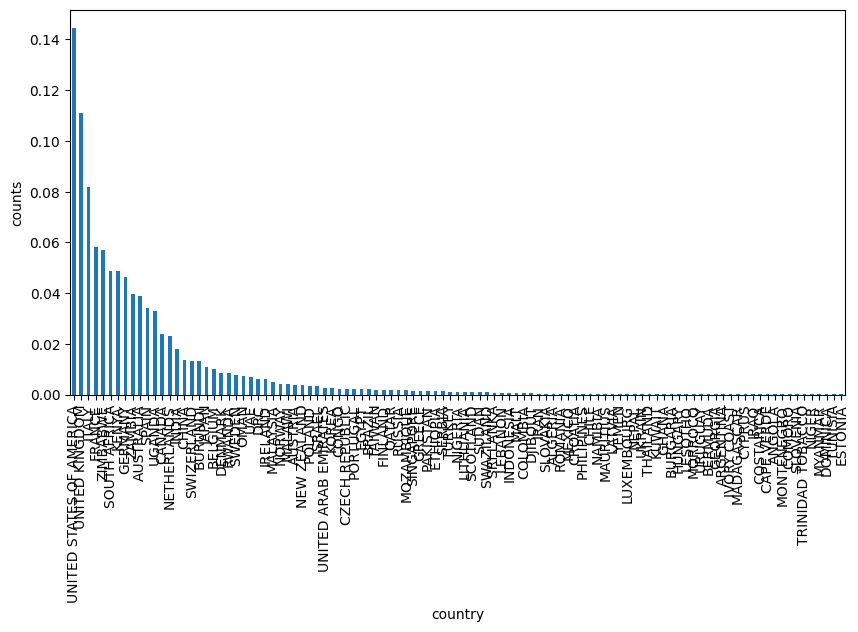

In [16]:
print(train['country'].value_counts())
plt.figure(figsize=(10,5))
train['country'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('country')


**Total Male and Total Female**

total_male
1.0     2961
0.0     1142
2.0      478
3.0      139
4.0       46
6.0       17
5.0       15
15.0       2
7.0        2
10.0       2
9.0        2
17.0       1
12.0       1
44.0       1
Name: count, dtype: int64


Text(0.5, 0, 'total_male')

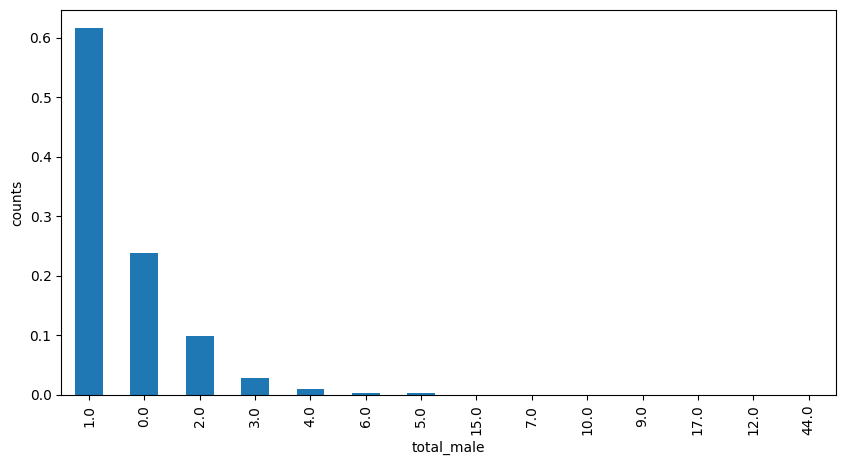

In [17]:
print(train['total_male'].value_counts())
plt.figure(figsize=(10,5))
train['total_male'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('total_male')

total_female
1.0     2418
0.0     1672
2.0      463
3.0      144
4.0       46
5.0       25
6.0       15
7.0       10
10.0       4
9.0        4
12.0       3
11.0       3
15.0       1
49.0       1
Name: count, dtype: int64


Text(0.5, 0, 'total_female')

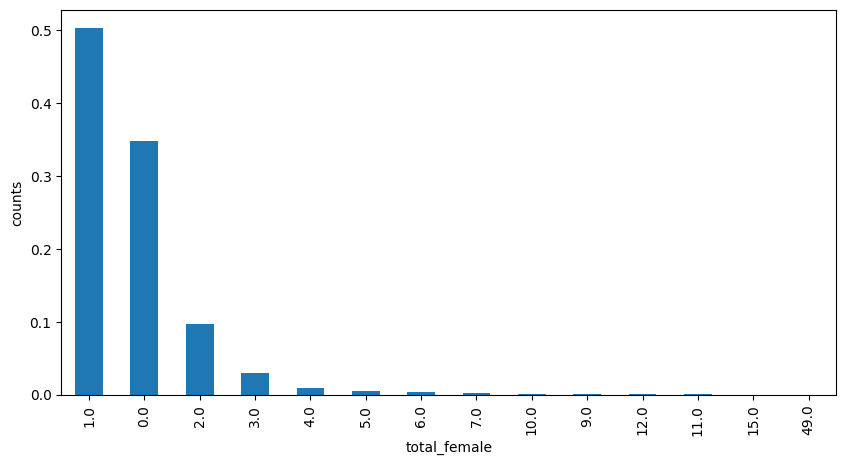

In [18]:
print(train['total_female'].value_counts())
plt.figure(figsize=(10,5))
train['total_female'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('total_female')

**Night Mainland and Night Zanzibar**

night_mainland
0.0      537
2.0      425
7.0      414
3.0      395
4.0      379
        ... 
66.0       1
130.0      1
69.0       1
120.0      1
145.0      1
Name: count, Length: 64, dtype: int64


Text(0.5, 0, 'night_mainland')

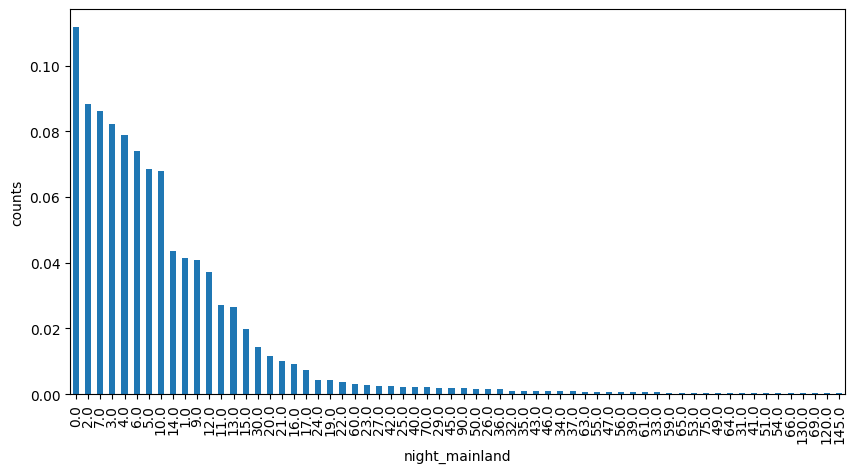

In [19]:
print(train['night_mainland'].value_counts())
plt.figure(figsize=(10,5))
train['night_mainland'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('night_mainland')

night_zanzibar
0.0     3023
7.0      367
4.0      282
3.0      261
5.0      229
6.0      184
2.0      128
10.0      62
14.0      50
1.0       48
9.0       39
11.0      25
13.0      25
12.0      22
15.0      17
17.0       9
30.0       4
25.0       4
19.0       4
43.0       3
16.0       3
22.0       3
26.0       2
23.0       2
27.0       2
60.0       2
20.0       2
21.0       1
24.0       1
33.0       1
35.0       1
31.0       1
50.0       1
61.0       1
Name: count, dtype: int64


Text(0.5, 0, 'night_zanzibar')

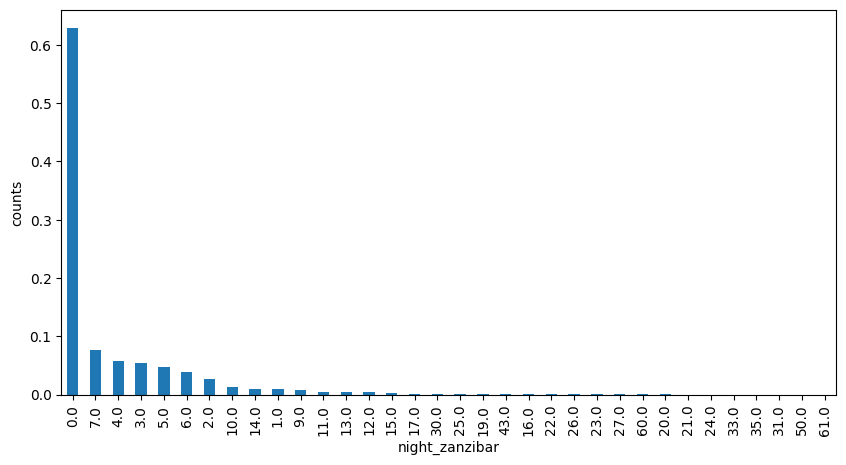

In [20]:
print(train['night_zanzibar'].value_counts())
plt.figure(figsize=(10,5))
train['night_zanzibar'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('night_zanzibar')

age_group
25-44    2487
45-64    1391
1-24      624
65+       307
Name: count, dtype: int64


Text(0.5, 0, 'age_group')

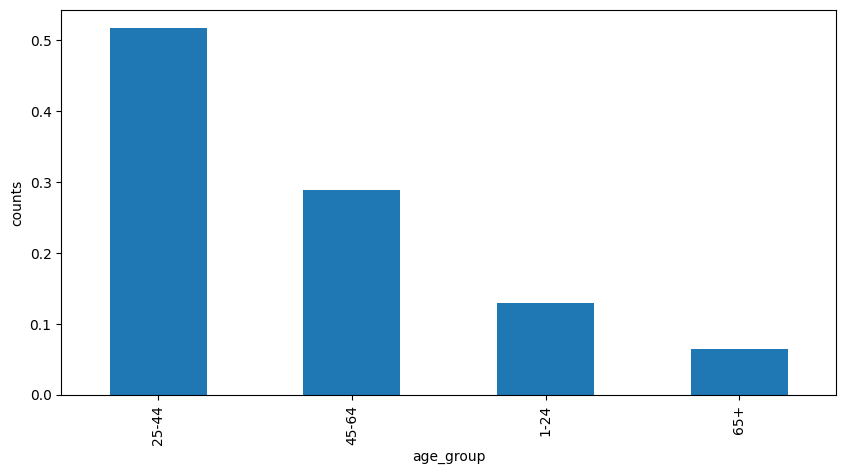

In [21]:
print(train['age_group'].value_counts())
plt.figure(figsize=(10,5))
train['age_group'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('age_group')

- > The above bar graph shows that the group 25-44 is the majority,showing that their energy levels is at its peek.

travel_with
Alone                  2379
Spouse                 1005
Friends/Relatives       895
Spouse and Children     368
Children                162
Name: count, dtype: int64


Text(0.5, 0, 'travel_with')

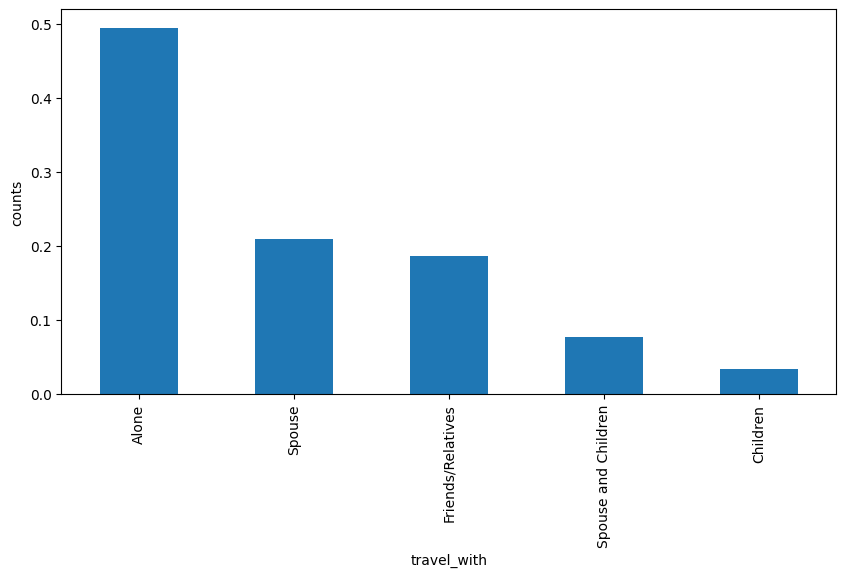

In [22]:
print(train['travel_with'].value_counts())
plt.figure(figsize=(10,5))
train['travel_with'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('travel_with')

- >The travel_with column shows that most people Travel alone

purpose
Leisure and Holidays              2840
Business                           671
Visiting Friends and Relatives     633
Meetings and Conference            312
Volunteering                       138
Other                              128
Scientific and Academic             87
Name: count, dtype: int64


Text(0.5, 0, 'purpose')

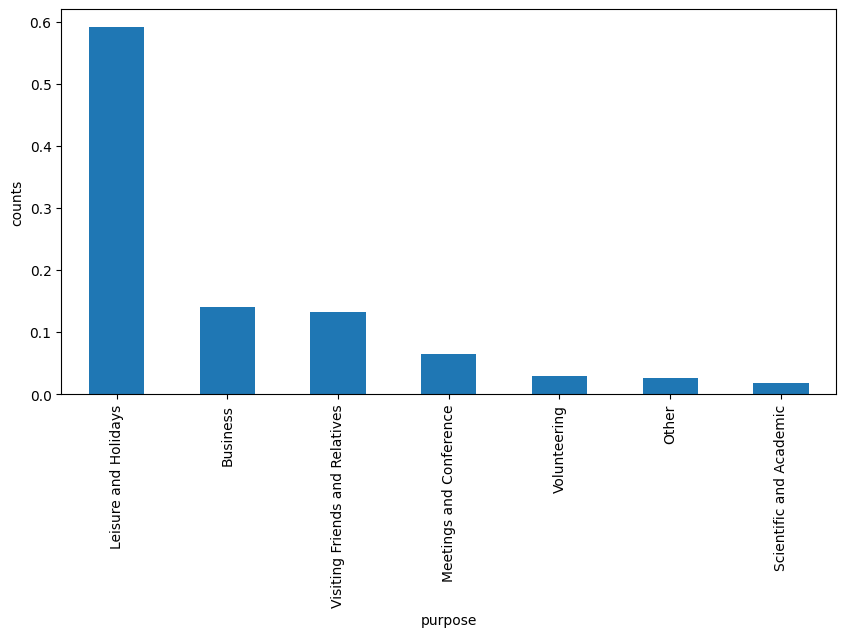

In [23]:
print(train['purpose'].value_counts())
plt.figure(figsize=(10,5))
train['purpose'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('purpose')

- > The above shows that most people travel to Tanzania for Leisure and on Holidays, followed by business. 

main_activity
Wildlife tourism            2259
Beach tourism               1025
Hunting tourism              457
Conference tourism           367
Cultural tourism             359
Mountain climbing            234
business                      58
Bird watching                 37
Diving and Sport Fishing      13
Name: count, dtype: int64


Text(0.5, 0, 'main_activity')

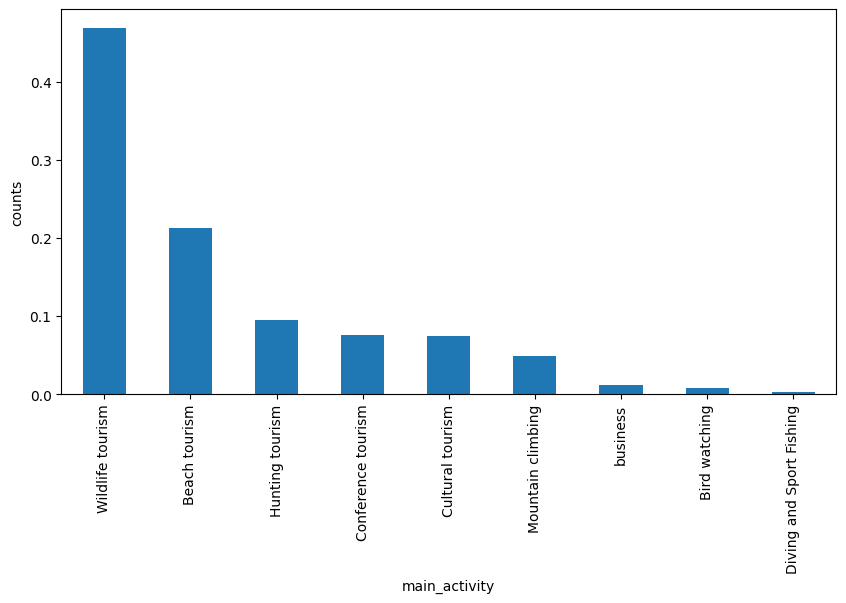

In [24]:
print(train['main_activity'].value_counts())
plt.figure(figsize=(10,5))
train['main_activity'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('main_activity')

- > This shows that the main activity that attracts visitors is Wildlife given that Tanzania is one of the leading countries in Africa with the best National parks and game reserves.

info_source
Travel, agent, tour operator      1913
Friends, relatives                1635
others                             490
Newspaper, magazines,brochures     359
Radio, TV, Web                     249
Trade fair                          77
Tanzania Mission Abroad             68
inflight magazines                  18
Name: count, dtype: int64


Text(0.5, 0, 'info_source')

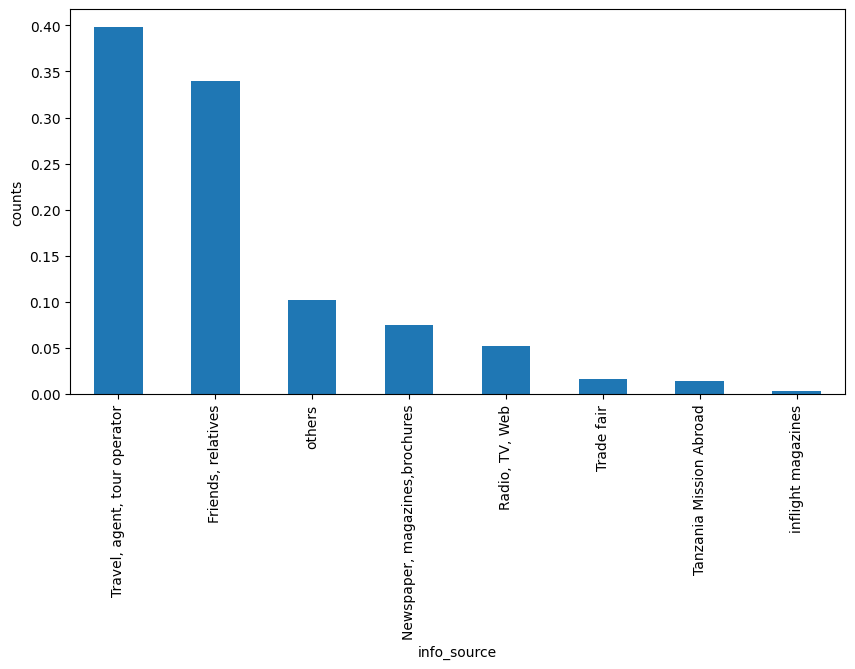

In [25]:
print(train['info_source'].value_counts())
plt.figure(figsize=(10,5))
train['info_source'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('info_source')

- > Travel Agencies and tour operators seem to be the leading info source for visitors

tour_arrangement
Independent     2570
Package Tour    2239
Name: count, dtype: int64


Text(0.5, 0, 'tour_arrangement')

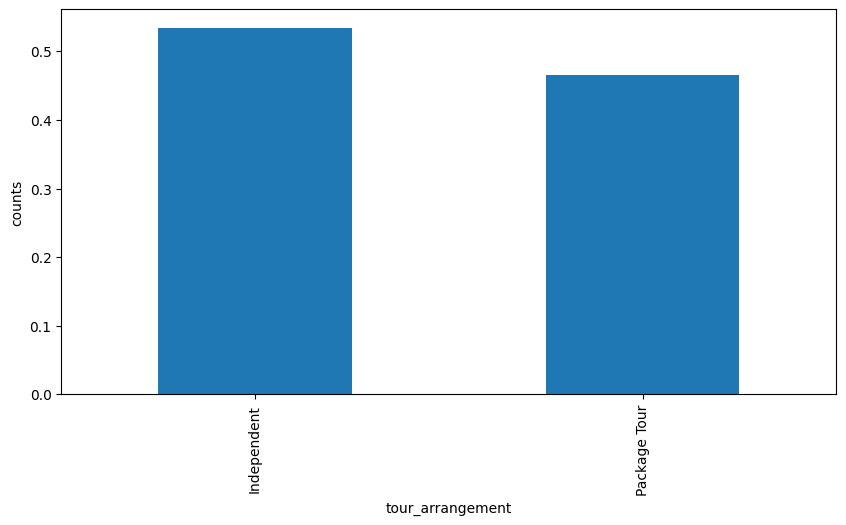

In [26]:
print(train['tour_arrangement'].value_counts())
plt.figure(figsize=(10,5))
train['tour_arrangement'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('tour_arrangement')

- > The tour_arrangement method here being independent and package tour do not have a big margin difference so the distribution is almost equal

**Package_transport_int**

package_transport_int
No     3357
Yes    1452
Name: count, dtype: int64


Text(0.5, 0, 'package_transport_int')

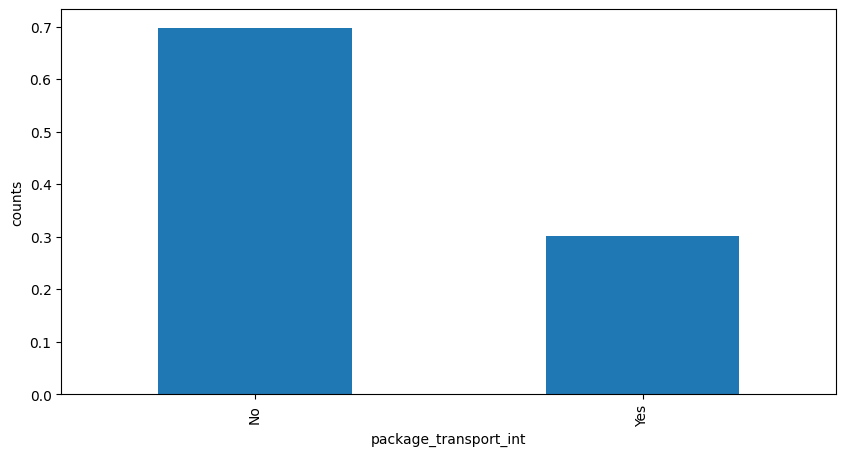

In [27]:
print(train['package_transport_int'].value_counts())
plt.figure(figsize=(10,5))
train['package_transport_int'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_transport_int')

- > For the majority travellers the international package was not provided

**Package_transport_tz**

package_transport_tz
No     2919
Yes    1890
Name: count, dtype: int64


Text(0.5, 0, 'package_transport_tz')

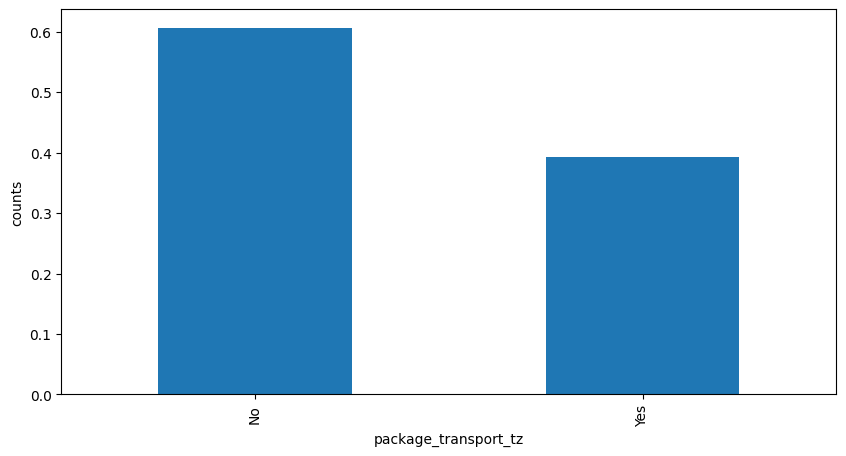

In [28]:
print(train['package_transport_tz'].value_counts())
plt.figure(figsize=(10,5))
train['package_transport_tz'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_transport_tz')

- > In this case the majority did not receive the Tanzania transport package

package_sightseeing
No     3319
Yes    1490
Name: count, dtype: int64


Text(0.5, 0, 'package_sightseeing')

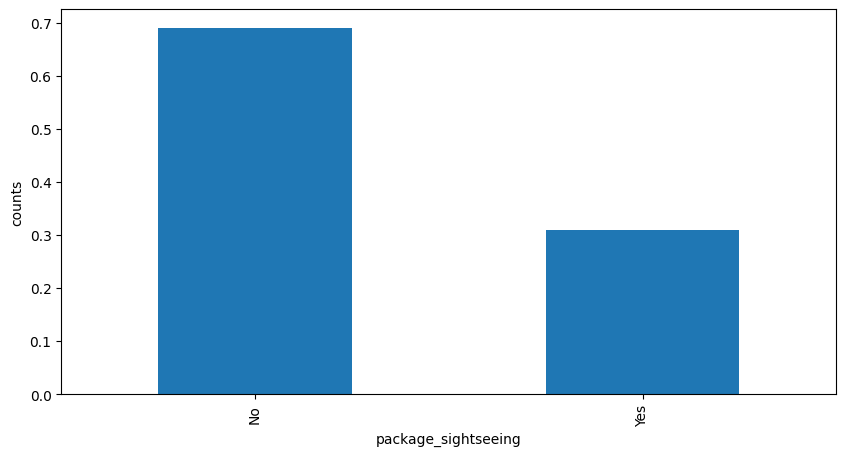

In [29]:
print(train['package_sightseeing'].value_counts())
plt.figure(figsize=(10,5))
train['package_sightseeing'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_sightseeing')

- > For the Majority the sightseeing package was not provided

package_guided_tour
No     3259
Yes    1550
Name: count, dtype: int64


Text(0.5, 0, 'package_guided_tour')

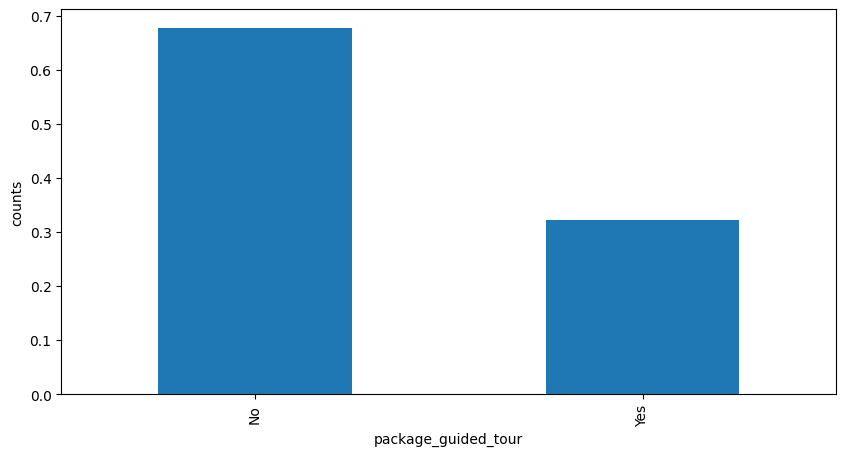

In [30]:
print(train['package_guided_tour'].value_counts())
plt.figure(figsize=(10,5))
train['package_guided_tour'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_guided_tour')

- > Fot the Majority the package guide tour was not provided

package_insurance
No     4079
Yes     730
Name: count, dtype: int64


Text(0.5, 0, 'package_insurance')

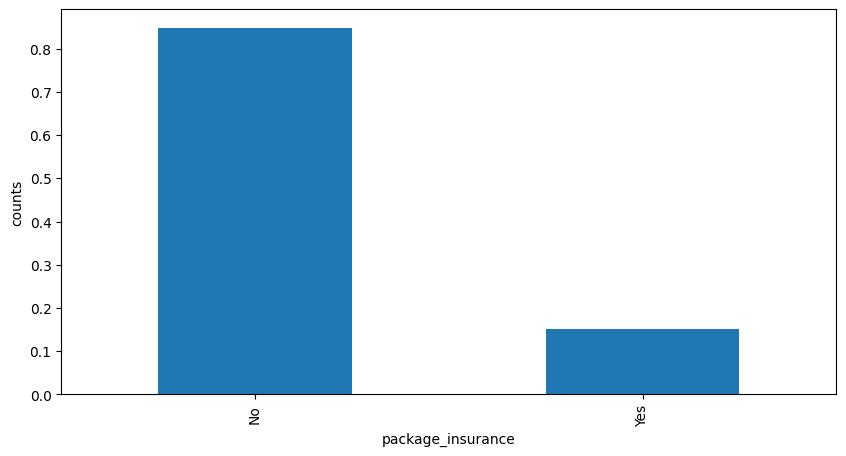

In [31]:
print(train['package_insurance'].value_counts())
plt.figure(figsize=(10,5))
train['package_insurance'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_insurance')

- > For the majority the package_insurance was not provided and the margin is so big showing that the distribution was imbalanced

first_trip_tz
Yes    3243
No     1566
Name: count, dtype: int64


Text(0.5, 0, 'first_trip_tz')

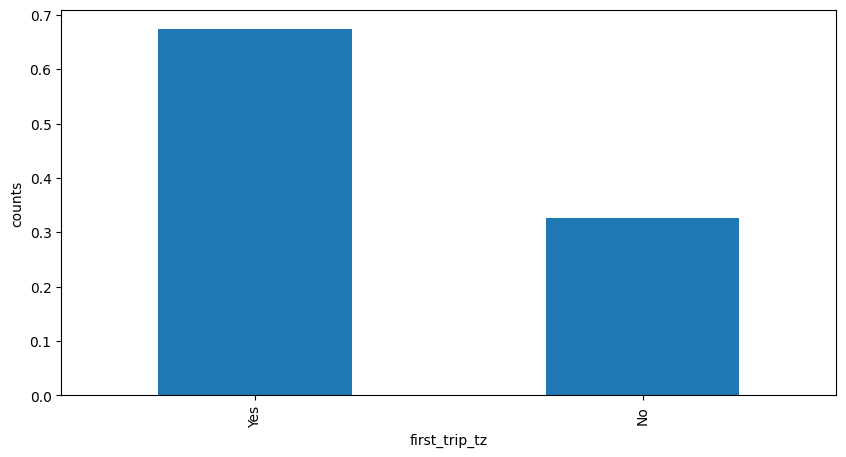

In [32]:
print(train['first_trip_tz'].value_counts())
plt.figure(figsize=(10,5))
train['first_trip_tz'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('first_trip_tz')

- > For the Mjority group it was their first trip to Tanzania

<Axes: xlabel='total_cost', ylabel='Density'>

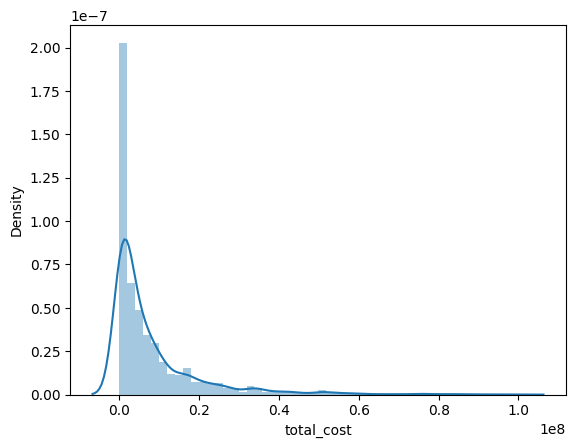

In [33]:
sns.distplot(train['total_cost'])

This shows that most values are more concentrated to the right so we could say that it is right skewed.

<Axes: xlabel='total_cost', ylabel='Density'>

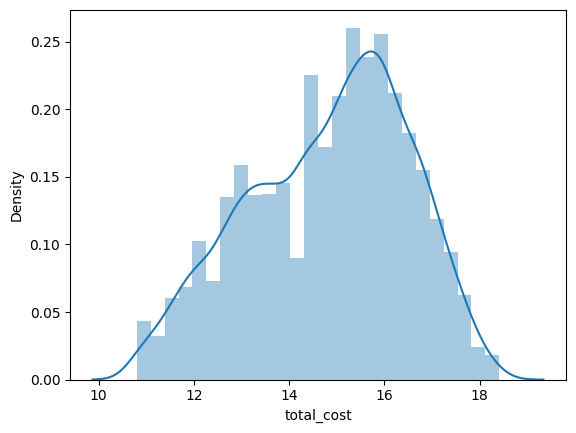

In [34]:
sns.distplot(np.log1p(train['total_cost']))

Adding the logs significantly reduce the skewness, making the data more normally distributed.

### 

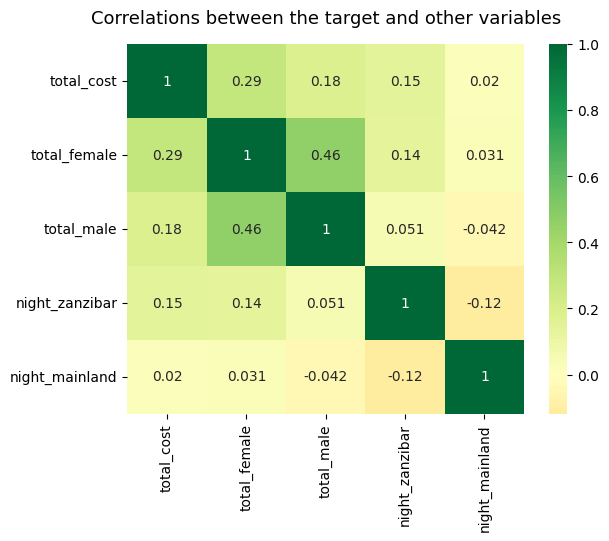

In [35]:
# Select only numerical features
train_num_df = train.select_dtypes(include=['number'])

top10_corrs = abs(train_num_df.corr()['total_cost']).sort_values(ascending = False).head(10)
corr = train_num_df[list(top10_corrs.index)].corr()
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlations between the target and other variables', pad = 15, fontdict={'size': 13})
plt.show()

### Feature Engineering

In [36]:
le = LabelEncoder()
def feature_engineer(train: pd.DataFrame, test: pd.DataFrame, target_col: str, id_col: str):
    data = pd.concat([train, test])
    
    # capping before feature interactions
    skewed = ['total_male','total_female','night_mainland','night_zanzibar']
    data[skewed].describe(percentiles=[0.05,0.95])

    #feature interactions
    data['total_travellers'] = data['total_male'] + data['total_female']
    data['total_nights'] = data['night_mainland'] + data['night_zanzibar']

    data['package_total'] = ""
    for col in ['package_transport_int', 'package_accomodation',
           'package_food', 'package_transport_tz', 'package_sightseeing',
           'package_guided_tour', 'package_insurance']:
            data['package_total'] += data[col]

    data['purpose_mainactivity'] = data['purpose'] + "_" + data['main_activity']
    data['total_travellers'] = np.log1p(data['total_travellers'])
    data['total_nights'] = np.log1p(data['total_nights'])
    
   #converting all your categorical columns to numerical
    categorical_cols = [col for col in data.select_dtypes('object').columns if col not in [id_col]]
    numerical_cols = [col for col in data.select_dtypes(['int', 'float']).columns]
    for col in categorical_cols:
        data[col] = le.fit_transform(data[col])
        
      #this part doesnt change
    independent_features = [col for col in data.columns if col not in [id_col, target_col, "split"]]
    dependent_feature = target_col
      
    train = data[data[id_col].isin(train[id_col].unique())]
    test = data[data[id_col].isin(test[id_col].unique())]

    return train, test, independent_features, dependent_feature

train_df, test_df, independent_features, dependent_feature = feature_engineer(train, test, "total_cost", "ID")

In [37]:
independent_features

['country',
 'age_group',
 'travel_with',
 'total_female',
 'total_male',
 'purpose',
 'main_activity',
 'info_source',
 'tour_arrangement',
 'package_transport_int',
 'package_accomodation',
 'package_food',
 'package_transport_tz',
 'package_sightseeing',
 'package_guided_tour',
 'package_insurance',
 'night_mainland',
 'night_zanzibar',
 'payment_mode',
 'first_trip_tz',
 'most_impressing',
 'total_travellers',
 'total_nights',
 'package_total',
 'purpose_mainactivity']

### Training and Evaluation

In [38]:
X = train_df[independent_features]
y = train_df[dependent_feature]

In [39]:
X.head()

,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_travellers,total_nights,package_total,purpose_mainactivity
0,101,3,2,1.0,1.0,1,7,0,0,0,0,0,0,0,0,0,13.0,0.0,0,0,2,1.098612,2.639057,0,16
1,111,2,0,1.0,0.0,1,3,7,0,0,0,0,0,0,0,0,14.0,7.0,0,1,6,0.693147,3.091042,0,12
2,111,2,0,0.0,1.0,5,3,0,0,0,0,0,0,0,0,0,1.0,31.0,0,0,1,0.693147,3.496508,0,41
3,111,2,3,1.0,1.0,1,7,5,1,0,1,1,1,1,1,0,11.0,0.0,0,1,2,1.098612,2.484907,34,16
4,17,0,0,1.0,0.0,1,7,5,0,0,0,0,0,0,0,0,7.0,4.0,0,1,4,0.693147,2.484907,0,16


In [40]:
y.head()

0     674602.5
1    3214906.5
2    3315000.0
3    7790250.0
4    1657500.0
Name: total_cost, dtype: float64

In [41]:
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# fold_pred = []
# oof_pred = np.zeros(len(X))  # Initialize the array to store out-of-fold predictions
# lgb_mae = []
# xgb_mae = []
# catt_mae = []
# params = {
#     'iterations': [500, 1000],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'depth': [6, 8, 10],
#     'l2_leaf_reg': [1, 3, 5, 7],
#     'random_state': [42]
# }

# for train_index, test_index in kf.split(X, y):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # Initializing our models
#     model_1 = lgb.LGBMRegressor(random_state=42)
#     model_2 = xgb.XGBRegressor(random_state=42)
#     model_3 = catt.CatBoostRegressor(random_state=42)

#     # Wrap LGBMRegressor's fit method to enable early stopping
#     fit_with_early_stopping = partial(
#         lgb.LGBMRegressor.fit,
#         eval_set=[(X_test, y_test)],
#         eval_metric='mae',
# #         verbose=False
#     )

#     # Fitting our models
#     fit_with_early_stopping(model_1, X_train, y_train)
#     model_2.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
#     model_3.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)

#     # Making predictions
#     pred_1 = model_1.predict(X_test)
#     pred_2 = model_2.predict(X_test)
#     pred_3 = model_3.predict(X_test)

#     # Calculate MAE for each model
#     lgb_mae.append(mean_absolute_error(y_test, pred_1))
#     xgb_mae.append(mean_absolute_error(y_test, pred_2))
#     catt_mae.append(mean_absolute_error(y_test, pred_3))

#     # Ensemble predictions
#     ensemble_pred = (pred_1 + pred_2 + pred_3) / 3
#     fold_pred.append(ensemble_pred)
    
#     # Out-of-fold predictions
#     oof_pred[test_index] = ensemble_pred
    
# # Concatenate predictions across folds
# fold_pred = np.concatenate(fold_pred)

# # Calculate overall mean absolute error (MAE) across folds for ensemble model
# overall_mae = mean_absolute_error(y, oof_pred)

# print("Overall Mean Absolute Error (Ensemble):", overall_mae)
# print("Mean Absolute Error (LightGBM):", np.mean(lgb_mae))
# print("Mean Absolute Error (XGBoost):", np.mean(xgb_mae))
# print("Mean Absolute Error (CatBoost):", np.mean(catt_mae))

In [42]:


# Define the CatBoost model parameters for grid search
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7],
    'random_state': [42]
}

# Initialize K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
fold_pred = []
oof_pred = np.zeros(len(X))  # Initialize the array to store out-of-fold predictions
catt_mae = []

# Initialize GridSearchCV with CatBoostRegressor
catboost_model = CatBoostRegressor(verbose=500)
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)

# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Perform grid search to find the best hyperparameters
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Fit the best model
    best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=250, verbose=500)

    # Making predictions
    pred = best_model.predict(X_test)

    # Calculate MAE for CatBoost model
    catt_mae.append(mean_absolute_error(y_test, pred))

    # Store fold predictions
    fold_pred.append(pred)
    
    # Out-of-fold predictions
    oof_pred[test_index] = pred
    
# Concatenate predictions across folds
fold_pred = np.concatenate(fold_pred)

# Calculate overall mean absolute error (MAE) across folds for CatBoost model
overall_mae = mean_absolute_error(y, oof_pred)

print("Overall Mean Absolute Error (CatBoost):", overall_mae)
print("Mean Absolute Error (CatBoost) per fold:", catt_mae)
print("Best Parameters from Grid Search:", grid_search.best_params_)


0:	learn: 12306420.8341987	total: 57.3ms	remaining: 28.6s
0:	learn: 12740363.0312569	total: 59.5ms	remaining: 29.7s
0:	learn: 11700114.4154775	total: 51.2ms	remaining: 25.5s
0:	learn: 12163193.8544067	total: 56ms	remaining: 28s
499:	learn: 8777307.8476003	total: 3.54s	remaining: 0us
499:	learn: 7596216.5452402	total: 3.45s	remaining: 0us
0:	learn: 11536609.1006405	total: 2.81ms	remaining: 1.4s
0:	learn: 12587691.1147602	total: 7.13ms	remaining: 3.56s
499:	learn: 8109740.8624134	total: 4.5s	remaining: 0us
499:	learn: 5204485.3927761	total: 4.29s	remaining: 0us
0:	learn: 11990017.5910278	total: 2.69ms	remaining: 1.34s
0:	learn: 11338328.3845913	total: 7.97ms	remaining: 3.98s
499:	learn: 5818396.1298166	total: 3.04s	remaining: 0us
0:	learn: 12403021.2941046	total: 6.42ms	remaining: 3.2s
499:	learn: 4963016.8808724	total: 3.85s	remaining: 0us
0:	learn: 12307823.8967478	total: 5.52ms	remaining: 2.75s
499:	learn: 3548473.0870643	total: 3.65s	remaining: 0us
0:	learn: 11701600.4139848	total: 1

Overall Mean Absolute Error (Ensemble): 4957069.625160386
Mean Absolute Error (CatBoost): 4957112.998708456

In [ ]:

    # Create a dataframe with 'ID' and 'preds' columns
sub = pd.DataFrame({'ID': test_df['ID'], 'preds': test_preds})

    # Save the dataframe to a CSV file
sub.to_csv('submission.csv', index=False)

In [ ]:
print(sub)